<div align="center"><font size="6">Szívbetegség</font></div>
<div align="center"><font size="3.5">Készítette: Balogh Kinga</font></div>


In [1]:
# alapvető matematikai műveletek
import numpy as np
# statisztikai csomagok
from scipy.stats import norm, kstest, ttest_ind

# Táblázathoz szükséges csomag
import pandas as pd
# ábrázoláshoz szükséges csomag
import matplotlib.pyplot as plt
import seaborn as sns
# Ábraméret: 10x7 inch
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10, 7)

Adattábla beltöltése:

In [2]:
df= pd.read_csv('dataset/heart.csv')

Első tíz sor:

In [3]:
df.head(10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
5,57,1,0,140,192,0,1,148,0,0.4,1,0,1,1
6,56,0,1,140,294,0,0,153,0,1.3,1,0,2,1
7,44,1,1,120,263,0,1,173,0,0.0,2,0,3,1
8,52,1,2,172,199,1,1,162,0,0.5,2,0,3,1
9,57,1,2,150,168,0,1,174,0,1.6,2,0,2,1


## Az oszlopok jelentései:

- age: kor
- sex: nem
  - 0: nő
  - 1: férfi
- cp: mellkasi fájdalom típusa
  - 0: tipikus angina
  - 1: atipikus angina
  - 2: nem anginális fájdalom
  - 3: tünetmentes
- trestbps: nyugalmi vérnyomás
- chol: koleszterinszint mg/dl
- fbs: vércukorszint 120 mg/dl-nél nagyobb (1) vagy kisebb (0)
- restecg: nyugalmi elektrokardiográfiai eredmények
  - 0: normál
  - 1: ST-T abnormális
  - 2: lehetséges vagy bizonyos hipertrófia
- thalach: maximális pulzusszám
- exang: terhelés indukálta a mellkasi fájdalmat
  - 0: nem
  - 1: igen
- oldpeak: ST csökkenése terhelés hatására a nyugalmi állapothoz képest
- slope: ST csúcs szegmens meredeksége
  - 0: növekvő
  - 1: lapos
  - 2: csökkenő
- ca: fluoroszkópiával megjelölt szívkamrák száma (0-3)
- thal: hemoglobin szám csökkent
  - 3: nem
  - 6: igen
  - 7: igen (visszafordítható)
- target: diagnózis
  - 0: nem beteg
  - 1: beteg


In [4]:
df.dtypes

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
target        int64
dtype: object

A legtöbb adatunk egész típusú az `oldpeak` kivételével, azonban "folytonos" adatok csak az `age`, `testbps`, `chol`, `thalach`, `oldpeak` oszlopokban vannak. A többi adat kategóriákra bontottak.

Hiányzó adatok száma: 

In [5]:
df.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

Nincs hiányzó adat.

Alapvető statisztikák:

In [6]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


### A kor és nem vizuális vizsgálata

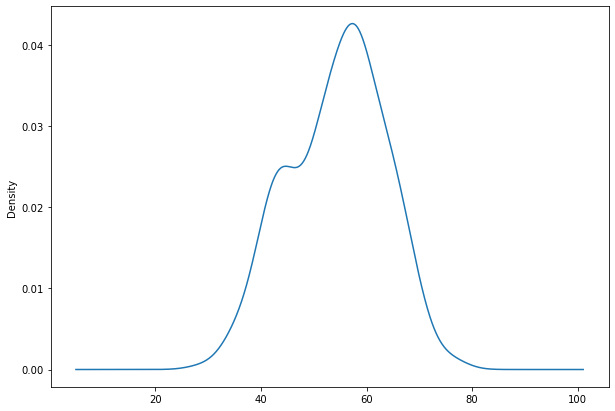

In [7]:
df['age'].plot(kind='kde');

A grafikon alapján az életkor adatok akár Gauss eloszlást is követhet. Illesszünk egy Gauss függvényt az adatsorra.

In [8]:
mu,sigma=norm.fit(df['age'])

In [9]:
mu

54.366336633663366

In [10]:
sigma

9.067101638577872

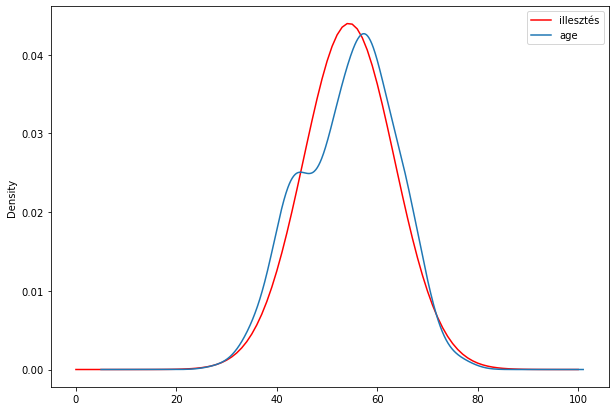

In [11]:
plt.plot(np.linspace(0,100,101),norm.pdf(np.linspace(0,100,101),mu,sigma),color='red',label='illesztés')
df['age'].plot(kind='kde')
plt.legend();

A Kolmogorov–Szmirnov próbával vizsgáljuk meg, hogy valóban normális eloszlást követ-e az adatsorban szereplő egyének kora.

In [12]:
kstest(df['age'],norm.cdf,(mu,sigma))

KstestResult(statistic=0.07631542379603462, pvalue=0.05562295181513114)

Értelmezés hiányzik még..

---
Vizsgáljuk tovább nemek szerint!

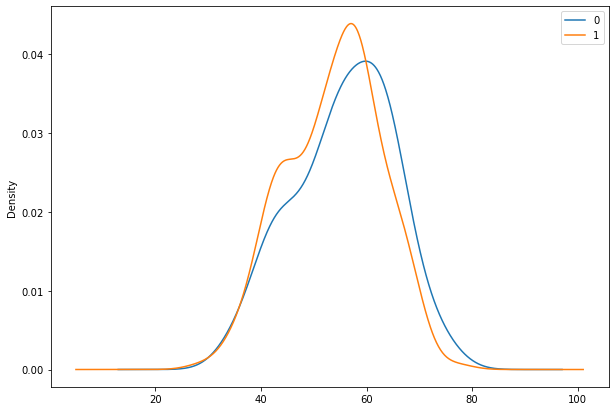

In [13]:
df.groupby('sex')['age'].plot(kind='kde',legend=True);

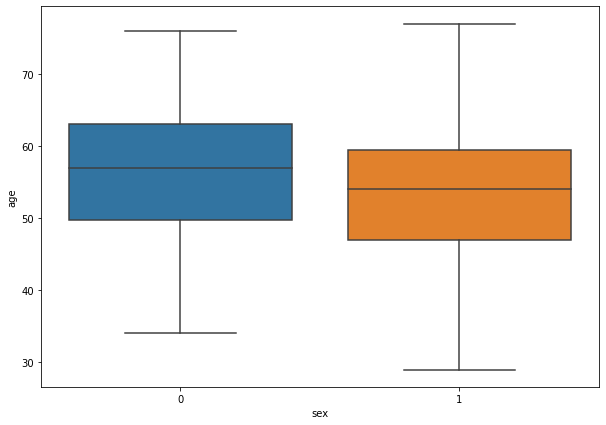

In [14]:
sns.boxplot(x="sex", y="age", data=df);

Tegyük fel, hogy a férfiak és a nők kora külün-külön is normális eloszlást követ. Welch-próbával vizsgáljuk meg, hogy a két csoport átlagéletkora jelentősen különböznek-e.

In [15]:
df.groupby('sex')['age'].mean()

sex
0    55.677083
1    53.758454
Name: age, dtype: float64

In [16]:
gb = df.groupby("sex")['age']
ttest_ind(*[gb.get_group(x) for x in gb.groups],equal_var=False)

Ttest_indResult(statistic=1.6804735761147427, pvalue=0.09463999476206374)

A $p=0.09$ vagyis elfogadjuk a nullhipotézist, miszerint a tesztben szereplő férfiak és a nők átlagéletkora nem különbözik jelentősen.

Nézzük meg a férfiak és nők arányát:

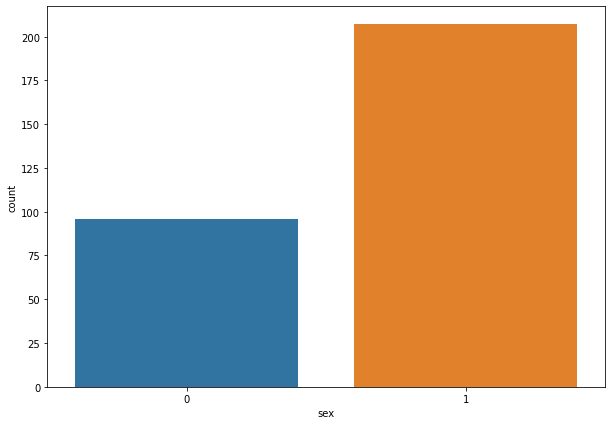

In [17]:
sns.countplot(x="sex", data=df);

A nők és férfiak száma jelentősen különbözik.

Pearson-féle korrelációs együtthatók:

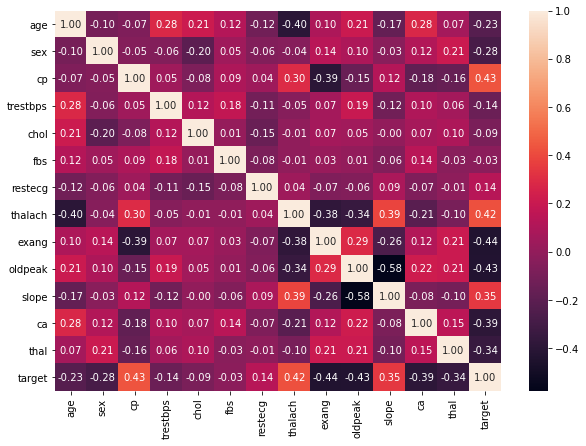

In [18]:
sns.heatmap(df.corr(), annot=True, fmt=".2f");

Vizsgáljuk a  `target` oszlop korrelációját a többi változóval. A korrelációs együtthatókból látszik, hogy a `cp`, `thalach`, `exang` és a `oldpeak` változók érdemes tovább vizsgálnunk. 